# What's Cooking? 
Description: This notebook performs supervised learning on the "What's Cooking?" dataset.

Models: 

Logistic Regression 

RandomForestClassifier

GradientBoostingClassifier

XGBoost 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from collections import Counter
import copy as cp
import pickle
import math


%matplotlib inline
pd.options.display.max_columns=100

## Helper functions

In [2]:
def splitTrainingTesting(X):
    """Split into trained and test sets"""
    df_test = X.sample(frac=.2, random_state=3) 
    df_train = X.drop(df_test.index)
    return df_test, df_train

## Load data 

In [3]:
# Load data and create BOW

data = pd.read_json('train.json')
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()


,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,"2 1/2 to 3 lb. chicken, cut into serving pieces",2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,2% milk shredded mozzarella cheese,2% reduced-fat milk,25% less sodium chicken broth,33% less sodium cooked deli ham,33% less sodium cooked ham,33% less sodium ham,33% less sodium smoked fully cooked ham,40% less sodium taco seasoning,40% less sodium taco seasoning mix,7 Up,"8 ounc ziti pasta, cook and drain",95% lean ground beef,A Taste of Thai Rice Noodles,Accent Seasoning,Adobo All Purpose Seasoning,Alaskan king crab legs,Alexia Waffle Fries,Alfredo sauce,Amarena cherries,Amaretti Cookies,American cheese,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,Asian sweet chili sauce,Azteca Flour Tortillas,BACARDI® Mixers Margarita Mix,BACARDI® Superior,BREAKSTONE'S Sour Cream,Baileys Irish Cream Liqueur,Balsamico Bianco,Barilla Linguine,Barilla Oven-Ready Lasagne,Barilla Plus Pasta,...,yellow chives,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow heirloom tomatoes,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin,yellowfin tuna,yellowtail,yellowtail snapper fillets,yoghurt,yoghurt natural low fat,yogurt cheese,yogurt dressing,yogurt low fat,yolk,yoplait,young coconut meat,young leeks,young nettle,yu choy,yuca,yucca,yucca root,yukon gold,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Supervised learning 

In [4]:
test, train = splitTrainingTesting(dataBinaryIngredients)

In [5]:
train_ids = train.index.values
test_ids = test.index.values

In [6]:
# begin with Logistic Regression
trainLabels = data.loc[train_ids, 'cuisine'].values
testLabels = data.loc[test_ids, 'cuisine'].values 

In [7]:
train.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,"2 1/2 to 3 lb. chicken, cut into serving pieces",2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,2% milk shredded mozzarella cheese,2% reduced-fat milk,25% less sodium chicken broth,33% less sodium cooked deli ham,33% less sodium cooked ham,33% less sodium ham,33% less sodium smoked fully cooked ham,40% less sodium taco seasoning,40% less sodium taco seasoning mix,7 Up,"8 ounc ziti pasta, cook and drain",95% lean ground beef,A Taste of Thai Rice Noodles,Accent Seasoning,Adobo All Purpose Seasoning,Alaskan king crab legs,Alexia Waffle Fries,Alfredo sauce,Amarena cherries,Amaretti Cookies,American cheese,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,Asian sweet chili sauce,Azteca Flour Tortillas,BACARDI® Mixers Margarita Mix,BACARDI® Superior,BREAKSTONE'S Sour Cream,Baileys Irish Cream Liqueur,Balsamico Bianco,Barilla Linguine,Barilla Oven-Ready Lasagne,Barilla Plus Pasta,...,yellow chives,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow heirloom tomatoes,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin,yellowfin tuna,yellowtail,yellowtail snapper fillets,yoghurt,yoghurt natural low fat,yogurt cheese,yogurt dressing,yogurt low fat,yolk,yoplait,young coconut meat,young leeks,young nettle,yu choy,yuca,yucca,yucca root,yukon gold,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Initial values 
X_train = train
y_train =trainLabels

X_test = test
y_test = testLabels


In [9]:
data['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [10]:
target_cuisines = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']


def fct(s):
    return target_cuisines.index(s)

fct = np.vectorize(fct)


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import count
import seaborn as sn
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [12]:
# Adapted from hw1 @Chris @Lili
'''
Create functions to run the classifiers and store results in 1 variable
'''

# Helpfer function for cross validation
def calcCrossval(model):
    scores = cross_val_score(model, X_train, y_train, cv=3)
    print("Cross Val Training Accuracy: " + str(round(scores.mean(),3)) + ", STD: " + str(round(scores.std()*2,3)))
    return scores

# Create a class that contains a model and all its variables
# In this case, the 'class' is just a variable of a model
# that contains the model's relevant variables such as fpr, tpr, etc. 

class modDetails:    
    # This creates an umbrella variable that stores evaluation metrics, and relevant data for each 
    # classifier:
    def __init__(self, predictionsTrain, predictionsTest, 
                classifier, train_cvscores, training_accuracy, test_accuracy, clf_report, 
                 cm, name):
        self.predictionsTrain = predictionsTrain
        self.predictionsTest = predictionsTest
        self.training_accuracy = training_accuracy
        self.test_accuracy = test_accuracy
        self.classifier = classifier
        self.train_cvscores = train_cvscores
        self.clf_report =  clf_report
        self.cm = cm
        self.name = name

print('done')

def runModel2(model,  X_train, X_test, name):
    print(name + '-'*50 + ' \n')
    
    # Train the Classifier
    # And obtain 10-fold cross validation results of the training
    
    tt = model.fit(X_train,y_train)
    
    train_cvscores = calcCrossval(model)
    
    print(str(type(tt)))
    
    
    # Calculate classifier accuracy on trained data and test data
    predictionsTrain = tt.predict(X_train)
    predictionsTest = tt.predict(X_test)
    

    training_accuracy = accuracy_score(y_train, predictionsTrain)
    test_accuracy = accuracy_score(y_test, predictionsTest)
    
    cm = confusion_matrix(y_test, predictionsTest)
    clf_report = classification_report(y_test, predictionsTest, target_names=target_cuisines)
    
    print('Training accuracy: ', training_accuracy)
    print('Test accuracy: ', test_accuracy)


  
    # Save results in one umbrella variable of the class modDetails  
    model_info = modDetails(predictionsTrain, predictionsTest, 
                            tt, train_cvscores, training_accuracy, test_accuracy, clf_report, cm,
                            name)
    return model_info

print('done')
            
'''
Run Classifiers
'''


done
done


'\nRun Classifiers\n'

## Feature Selection

In [13]:
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
def get_feature_names(selector, dataBinaryIngredients):
    """
    Returns feature names from array of indices
    selector: selectKBest 
    dataBinaryIngredients: dataframe
    """
    mask = selector.get_support(indices=True) #list of booleans
    column_names = dataBinaryIngredients.columns
    feature_names = column_names[mask].values
    return feature_names


In [14]:
from sklearn.feature_selection import RFE
# recursive feature elimination (RFE) ### Takes a lot of time 
def fs(model):
    selector = RFE(model, 10, step=1)
    selector.fit(X_train, y_train)
    print('10 most significant variables, with corresponding coefficients')
    index = 0
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            print(i, selector.estimator_.coef_[0][index])
            index = index + 1
            

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20)
selector.fit_transform(X_train, y_train)
list(get_feature_names(selector, dataBinaryIngredients))

['Gochujang base',
 'cachaca',
 'cajun seasoning',
 'coconut milk',
 'corn starch',
 'corn tortillas',
 'couscous',
 'cumin seed',
 'feta cheese crumbles',
 'fish sauce',
 'garam masala',
 'grated parmesan cheese',
 'ground cumin',
 'ground turmeric',
 'kimchi',
 'mirin',
 'rice vinegar',
 'sake',
 'sesame oil',
 'soy sauce']

In [16]:
# get feature names
# mask = selector.get_support(indices= True)

# for i in mask:
#     print(dataBinaryIngredients.iloc[:, i].name)

# X_new.shape

## Dimensionality Reduction

In [17]:
# Reset to initial values. 
X_train = train
y_train =trainLabels

X_test = test
y_test = testLabels

In [18]:
train.shape

(31819, 6714)

In [19]:
# # Dimensionality reduction with truncated SVD. Skip and do feature selection.  

# #pca, source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# #https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/
# # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA, TruncatedSVD#actually using truncated svd instead of pca -- X is too large and sparse for PCA


# # number of components 
# n_components = 1000
# #rescale??? 
# scaler = StandardScaler()
# XtrainRescaled = scaler.fit_transform(X_train)
# XtestRescaled = scaler.transform(X_test)
# print('done rescaling')

# pca = TruncatedSVD(n_components= n_components)
# principalComps = pca.fit_transform(X_train) # new X_train
# principalCompsTest = pca.transform(X_test) # new X_test
# print('done principal components')

# # pcaRescaled = TruncatedSVD(n_components=n_components)
# # principalCompsRescaled = pcaRescaled.fit_transform(XtrainRescaled)
# # principalCompsRescaledTest = pcaRescaled.transform(XtestRescaled)
# # print('done principal components rescaled')


In [20]:
# pca.explained_variance_ratio_.sum() # 0.8978957710784204: 1000 principal components explain 90% of the variance. (We have enough princip components)

In [21]:
# # Set data to reduced dims, otherwise takes too long 
# print("Initial X_train.shape ", X_train.shape)
# print("Initial y_train.shape ", y_train.shape)
# print("Initial X_test.shape ", X_test.shape)
# print("Inital y_test.shape ", y_test.shape)


In [22]:
# X_train = principalComps
# X_test = principalCompsTest
# print("New X_train.shape ", X_train.shape)
# print("New X_test.shape ", X_test.shape)


## Run Models 

In [23]:
# Plot confusion matrix: https://flothesof.github.io/kaggle-whats-cooking-machine-learning.html?fbclid=IwAR2OXhDXtZ4LRf_K7TO6x2L2d6T3O6-XNtQ1Y4mqTUB1BH7yqGCkaVWiWjM
def plot_cm(model):
    """
    Plot confusion matrix. 
    """
    plt.figure(figsize=(10, 10))

    cm = model.cm # confusion_matrix(y_test, predictionsTest)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title("confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = target_cuisines
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, cuisines, rotation=90)
    plt.yticks(tick_marks, cuisines)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### 1. Logistic Regression

In [24]:
# feature selection
from sklearn.feature_selection import SelectFromModel

# Reset to initial values. 
X_train = train
y_train =trainLabels
X_test = test
y_test = testLabels


# define model
xgb = LogisticRegression()
# feature extraction
select_model = SelectFromModel(xgb)
# fit on train set
fit = select_model.fit(X_train, y_train)
# transform train set
X_trainLR = fit.transform(X_train)
# transform test set
X_testLR = fit.transform(X_test)

In [25]:
X_trainLR.shape

(31819, 2309)

In [26]:
X_testLR.shape

(7955, 2309)

In [27]:
%%time
logregL1 = LogisticRegression(C = 1, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
logregL1_info = runModel2(logregL1, X_trainLR, X_testLR, 'LogRegL1')




LogRegL1-------------------------------------------------- 

Cross Val Training Accuracy: 0.766, STD: 0.001
<class 'sklearn.linear_model.logistic.LogisticRegression'>
Training accuracy:  0.8787516892422766
Test accuracy:  0.766436203645506
CPU times: user 6min 2s, sys: 10.2 s, total: 6min 12s
Wall time: 3min 18s


In [28]:
print(logregL1_info.clf_report)

              precision    recall  f1-score   support

       greek       0.76      0.51      0.61        99
 southern_us       0.55      0.44      0.49       155
    filipino       0.75      0.67      0.71       326
      indian       0.78      0.82      0.80       504
    jamaican       0.68      0.61      0.64       142
     spanish       0.58      0.65      0.62       541
     italian       0.77      0.60      0.68       238
     mexican       0.86      0.87      0.87       604
     chinese       0.65      0.40      0.50       141
     british       0.78      0.88      0.83      1542
        thai       0.84      0.66      0.74       106
  vietnamese       0.77      0.68      0.72       294
cajun_creole       0.83      0.72      0.77       156
   brazilian       0.89      0.90      0.90      1280
      french       0.81      0.71      0.76       184
    japanese       0.68      0.51      0.58        97
       irish       0.70      0.80      0.75       880
      korean       0.54    

In [29]:
# Visualise 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


Text(0.5,64.6,'Predicted label')

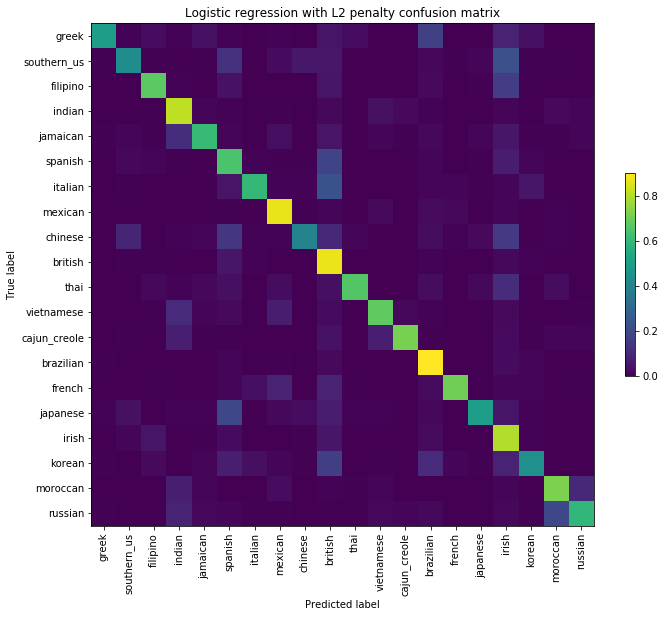

In [30]:
# Plot confusion matrix: https://flothesof.github.io/kaggle-whats-cooking-machine-learning.html?fbclid=IwAR2OXhDXtZ4LRf_K7TO6x2L2d6T3O6-XNtQ1Y4mqTUB1BH7yqGCkaVWiWjM
plt.figure(figsize=(10, 10))

cm = logregL1_info.cm # confusion_matrix(y_test, predictionsTest)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("Logistic regression with L2 penalty confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = target_cuisines
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


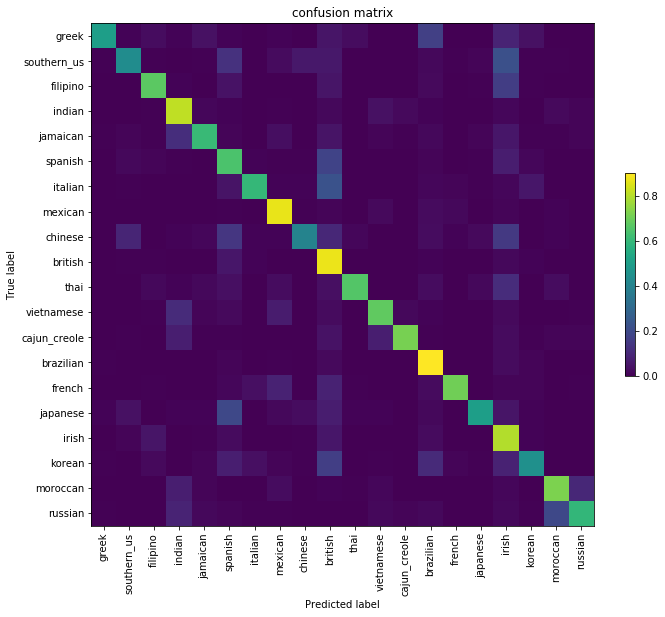

In [ ]:
plot_cm(logregL1_info)

### 2. XGBoost 

In [ ]:
# feature selection
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
# Reset to initial values. 
X_train = train
X_test = test


# define model
xgb = XGBClassifier(n_estimators=1, max_depth=2, random_state=0)
# feature extraction
select_model = SelectFromModel(xgb)
# fit on train set
fit = select_model.fit(X_train, y_train)
# transform train set
X_trainXgb = fit.transform(X_train)
# transform test set
X_testXgb = fit.transform(X_test)

In [ ]:
X_trainLR

In [ ]:


clf = Pipeline([
  ('feature_selection', SelectFromModel(XGBClassifier())),
  ('classification', RandomForestClassifier())
])


In [ ]:
X_trainXgb.shape

In [ ]:
X_testXgb.shape

In [ ]:
xgb = XGBClassifier(n_estimators=1, max_depth=2, random_state=0)
xgb_info = runModel2(xgb, X_train, X_test, "XG Boost")

In [ ]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(objective="multi:softprob", random_state=0)
xgb_info = runModel2(xgb, "XG Boost")

### 3. RandomForest 

In [ ]:
# Reset data to initial values. 
X_train = train
X_test = test


In [ ]:
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
# Reset to initial values. 
X_train = train
X_test = test

# define model
rfc = RandomForestClassifier()
# feature extraction
select_model = SelectFromModel(rfc)
# fit on train set
fit = select_model.fit(X_train, y_train)
# transform train set
X_trainRfc = fit.transform(X_train)
# transform test set
X_testRfc = fit.transform(X_test)

In [ ]:
X_trainRfc.shape

In [ ]:
X_testRfc.shape

In [ ]:
%%time
# run model

rf = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0)
rf_info = runModel2(rf, X_trainRfc, X_testRfc, 'Random Forest')

In [ ]:
print(rf_info.clf_report)

### 4. Gradient Boosting 

In [ ]:
# Reset data to initial values. 
X_train = train
X_test = test


In [ ]:
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
# Reset to initial values. 
X_train = train
X_test = test

# define model
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=10, random_state=0) # n_estimators=100, max_depth=100

# feature extraction
select_model = SelectFromModel(gbc)
# fit on train set
fit = select_model.fit(X_train, y_train)
# transform train set
X_trainGbc = fit.transform(X_train)
# transform test set
X_testGbc = fit.transform(X_test)

In [ ]:
%%time
# run model 
gbc_info = runModel2(gbc, X_trainGbc, X_testGbc,'Gradient Boost')